In [1]:
import pandas as pd
import numpy as np
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, roc_auc_score
from keras import backend as K
import matplotlib.pyplot as plt
from datetime import timedelta
import sys
sys.path.insert(1, '/Users/yuesongyang/Desktop/BT4222_repo')
from backtest import *

In [2]:
features = pd.read_csv("../../cooked_complete_dataset.csv")

In [3]:
features.dropna(inplace = True)

In [4]:
features['date'] = features['date'].apply(lambda x: datetime.datetime.strptime(x, "%d/%m/%y"))
features["date"] = pd.to_datetime(features["date"], format='%d/%m/%Y', infer_datetime_format=True)

In [5]:
features["class_y"] = features["Adj_Close_BTC-USD"].shift(1).dropna()
features["class_y"] = features.apply(lambda x : 1 if x["class_y"] < x["Adj_Close_BTC-USD"] else 0 , axis = 1)

In [6]:
features.head()

,date,Adj_Close_BTC-USD,Open_BTC-USD,High_BTC-USD,Low_BTC-USD,Volume_BTC-USD,Adj_Close_SPY,Adj_Close_GLD,Adj_Close_CHFUSD=X,Adj_Close_CNYUSD=X,Adj_Close_EURUSD=X,Adj_Close_GBPUSD=X,Adj_Close_JPYUSD=X,coindesk_sentiment,num_of_coindesk_posts,reddit_comments_sentiments,top_50_reddit_posts_sentiments,blockchain_transactions_per_block,blockchain_hash_rates,class_y
0,2020-12-14,19246.64453,19144.49219,19305.09961,19012.70898,2.247400e+10,361.926788,171.539993,1.125442,0.152772,1.213340,1.331824,0.009621,0.249489,12,0.188275,0.297238,2167.931034,134533587.6,0
1,2020-12-15,19417.07617,19246.91992,19525.00781,19079.84180,2.674198e+10,366.819824,173.940002,1.127930,0.152679,1.214890,1.333084,0.009614,0.173773,18,0.144389,0.399427,2288.857143,133351912.2,1
2,2020-12-16,21310.59766,19418.81836,21458.90820,19298.31641,4.440901e+10,367.395508,174.899994,1.129382,0.152945,1.215430,1.344447,0.009649,0.341491,11,0.137256,0.489673,2204.314685,132323572.3,1
3,2020-12-17,22805.16211,21308.35156,23642.66016,21234.67578,7.137861e+10,369.449982,176.740005,1.129446,0.153109,1.219959,1.350293,0.009664,0.197572,10,0.156723,0.636030,2399.077519,132373208.7,1
4,2020-12-18,23137.96094,22806.79688,23238.60156,22399.81250,4.038790e+10,367.974792,176.440002,1.130301,0.153090,1.226272,1.357018,0.009696,0.315601,2,0.166419,0.107093,2392.031847,131791042.0,1


**Log transform the features. Features are time series by nature and log transformation makes it stationary.**

In [7]:
# def log_return_transformation(df, columns='all'):
#     if columns == 'all':
#         for column in list(df.columns):
#             if column != 'date':
#                 # log rate of change
#                 df[column] = np.log(df[column]/df[column].shift(1))
#     else:
#         for column in columns:
#                 df[column] = np.log(df[column]/df[column].shift(1))

#     df = df.dropna()
#     return df

# features = log_return_transformation(features, 
#                                      columns = features.drop(
#                                          ['date', 'Adj_Close_BTC-USD', 'coindesk_sentiment',
#                                          'num_of_coindesk_posts', ''], axis = 1).columns.tolist())

**Helper functions to create lags for features and calculate RMSE**

In [8]:
def lag(data, dic):
    cols = []
    for key, value in dic.items():
        for i in range(1, value+1):
            cols.append(data[key].shift(i).rename('{}_lag{}'.format(data[key].name, i)))
    return pd.concat([data["date"],data["class_y"]] + cols, axis = 1)

## Without Sentiments

#### 1. Create feature lags

In [9]:
feature_lags = {"Adj_Close_BTC-USD" : 2, 
                "Volume_BTC-USD" : 1, 
                "Adj_Close_SPY" : 1,
                "Adj_Close_GLD" : 1,
                "Adj_Close_CHFUSD=X" : 1,
                "Adj_Close_CNYUSD=X" : 1,
                "Adj_Close_EURUSD=X" : 1,
                "Adj_Close_GBPUSD=X" : 1,
                "Adj_Close_JPYUSD=X" : 1,
                "blockchain_transactions_per_block" : 1,
                "blockchain_hash_rates" : 1}

data = lag(features, feature_lags)

#### 2. Handle train-test split

In [10]:
# data['date'] = data['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
# data["date"] = pd.to_datetime(data["date"], format='%d/%m/%Y', infer_datetime_format=True)
data = data[data["date"] >= "1/1/2021"]

train = data[data["date"] <= "2021-03-10"]
test = data[(data["date"] > "2021-03-10") & (data["date"] <= "2021-04-5")]

x_train = train.drop(["date", "class_y"], axis = 1)
y_train = train["class_y"]

x_test = test.drop(["date", "class_y"], axis = 1)
y_test = test["class_y"]

#### 3. MinMax scale the features

In [11]:
sc = MinMaxScaler(feature_range = (0, 1))
sc.fit(x_train)
x_train_trans = sc.transform(x_train)
x_test_trans = sc.transform(x_test)

#### 4. Transform the feature shapes to fit into LSTM

In [12]:
x_train_trans = x_train_trans.reshape(x_train_trans.shape[0], x_train_trans.shape[1], 1)
x_test_trans = x_test_trans.reshape(x_test_trans.shape[0], x_test_trans.shape[1], 1)

#### 5. Define a Grid Search function

In [17]:
def LSTM_GS(layer_spe, time_step):
    regressor = Sequential()
    count = 0
    for unit in layer_spe:
        count += 1 
        if len(layer_spe) == 1:
            regressor.add(LSTM(unit, activation = "relu", input_shape = (time_step, 1))) # batch size, time steps, data dimension
            regressor.add(Dropout(0.3))
        else:
            if count == 1:
                regressor.add(LSTM(unit, activation = "relu", return_sequences=True, input_shape = (time_step, 1))) # batch size, time steps, data dimension
                regressor.add(Dropout(0.3))
            elif count < len(layer_spe): 
                regressor.add(LSTM(unit, activation = "relu", return_sequences=True))
                regressor.add(Dropout(0.3))
            else:
                regressor.add(LSTM(unit, activation = "relu"))
                regressor.add(Dropout(0.3))
            
    regressor.add(Dense(units = 1, activation = "sigmoid"))
    regressor.compile(optimizer = 'Adam', loss = "binary_crossentropy", metrics=['accuracy'])
    regressor.fit(x_train_trans, y_train, epochs = 200, verbose = 0)
    
    yhat = regressor.predict(x_test_trans)
    return roc_auc_score(y_train, regressor.predict(x_train_trans)), roc_auc_score(y_test, yhat)

#### 6. Grid Search on a few hyperparameters combinations

In [18]:
res = []
# 1 layer
for unit in (4,8,16,32):
    for time_step in (1,2,3,4,5):
        res.append((([unit],time_step),LSTM_GS([unit], time_step)))

# 2 layers
for unit in (8,16,32):
    for time_step in (1,2,3,4,5):
        res.append((([unit, unit//2],time_step),LSTM_GS([unit, unit//2], time_step)))

# 3 layers
for unit in (8,16,32):
    for time_step in (1,2,3,4,5):
        res.append((([unit, unit//2, unit//4],time_step),LSTM_GS([unit, unit//2, unit//4], time_step)))

In [37]:
sorted(res, key = lambda x : x[1][1], reverse = True)[0]

(([4], 1), (0.5, 0.7151515151515151))

In [43]:
layer_config = sorted(res, key = lambda x : x[1][1], reverse = True)[0][0][0]
time_config = sorted(res, key = lambda x : x[1][1], reverse = True)[0][0][1]

#### 7. Define a function to retrain the model with selected hyperparameters and all data avilable

In [44]:
x_refit = data.drop(["date", "class_y"], axis = 1)
y_refit = data["class_y"]
x_refit_trans = sc.transform(x_refit)
x_refit_trans = x_refit_trans.reshape(x_refit_trans.shape[0], x_refit_trans.shape[1], 1)

In [45]:
def LSTM_pipe(layer_spe, time_step):
    regressor = Sequential()
    count = 0
    for unit in layer_spe:
        count += 1 
        if len(layer_spe) == 1:
            regressor.add(LSTM(unit, activation = "relu", input_shape = (time_step, 1))) # batch size, time steps, data dimension
            regressor.add(Dropout(0.3))
        else:
            if count == 1:
                regressor.add(LSTM(unit, activation = "relu", return_sequences=True, input_shape = (time_step, 1))) # batch size, time steps, data dimension
                regressor.add(Dropout(0.3))
            elif count < len(layer_spe): 
                regressor.add(LSTM(unit, activation = "relu", return_sequences=True))
                regressor.add(Dropout(0.3))
            else:
                regressor.add(LSTM(unit, activation = "relu"))
                regressor.add(Dropout(0.3))
            
    regressor.add(Dense(units = 1, activation = "sigmoid"))
    regressor.compile(optimizer = 'Adam', loss = "binary_crossentropy", metrics=['accuracy'])
    regressor.fit(x_train_trans, y_train, epochs = 200, verbose = 0)
    
    return regressor

In [46]:
model = LSTM_pipe(layer_config, time_config)

#### 8. Backtesting

In [47]:
# predicted value
yhat = model.predict(x_refit_trans, verbose=0)
yhat = [1 if x[0] > 0.5 else 0 for x in yhat]

In [48]:
for b in yhat:
    print(b)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [49]:
# weighted sentiments
sentiments = features[features["date"].isin(data.date)]
sentiments = sentiments["reddit_comments_sentiments"] + sentiments["top_50_reddit_posts_sentiments"]
sentiments = ["positive" if x > np.mean(sentiments) else "negative" for x in sentiments]

In [50]:
returns_without_adj = backtest_classification_noSentiment(yhat, 
                                                      data.date.tolist(), 
                                                      "LSTM_classification_no_sentiment")

In [51]:
returns_with_adj = backtest_classification_WithSentiment(yhat, 
                                  data.date.tolist(), 
                                  sentiments, "LSTM_classification_with_sentiment")

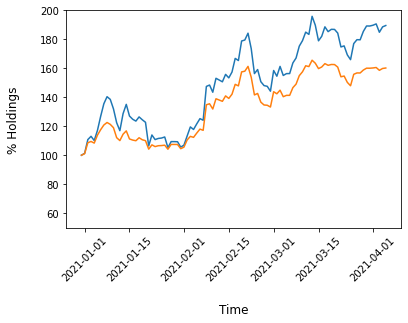

In [52]:
plt.plot([data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist(), [100*x for x in returns_without_adj])
plt.plot([data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist(), [100*x for x in returns_with_adj])
plt.xticks(rotation = 45)
plt.ylim(bottom =50, top = 200)
plt.ylabel("% Holdings", labelpad = 20, fontsize = 12)
plt.xlabel("Time", labelpad = 20, fontsize = 12)
plt.show()

## With Sentiments

In [35]:
feature_lags = {"Adj_Close_BTC-USD" : 2, 
                "Volume_BTC-USD" : 1, 
                "Adj_Close_SPY" : 1,
                "Adj_Close_GLD" : 1,
                "Adj_Close_CHFUSD=X" : 1,
                "Adj_Close_CNYUSD=X" : 1,
                "Adj_Close_EURUSD=X" : 1,
                "Adj_Close_GBPUSD=X" : 1,
                "Adj_Close_JPYUSD=X" : 1,
                "blockchain_transactions_per_block" : 1,
                "blockchain_hash_rates" : 1,
                "coindesk_sentiment" : 1,
                "num_of_coindesk_posts" : 1,
                "reddit_comments_sentiments" : 1,
                "top_50_reddit_posts_sentiments" : 1}

data = lag(features, feature_lags)
data = data[data["date"] >= "1/1/2021"]

train = data[data["date"] <= "2021-03-10"]
test = data[(data["date"] > "2021-03-10") & (data["date"] <= "2021-04-5")]

x_train = train.drop(["date", "class_y"], axis = 1)
y_train = train["class_y"]

x_test = test.drop(["date", "class_y"], axis = 1)
y_test = test["class_y"]

sc = MinMaxScaler(feature_range = (0, 1))
sc.fit(x_train)
x_train_trans = sc.transform(x_train)
x_test_trans = sc.transform(x_test)

x_train_trans = x_train_trans.reshape(x_train_trans.shape[0], x_train_trans.shape[1], 1)
x_test_trans = x_test_trans.reshape(x_test_trans.shape[0], x_test_trans.shape[1], 1)

In [36]:
res2 = []
# 1 layer
for unit in (4,8,16,32):
    for time_step in (1,2,3,4,5):
        res2.append((([unit],time_step),LSTM_GS([unit], time_step)))

# 2 layers
for unit in (8,16,32):
    for time_step in (1,2,3,4,5):
        res2.append((([unit, unit//2],time_step),LSTM_GS([unit, unit//2], time_step)))

# 3 layers
for unit in (8,16,32):
    for time_step in (1,2,3,4,5):
        res2.append((([unit, unit//2, unit//4],time_step),LSTM_GS([unit, unit//2, unit//4], time_step)))

In [53]:
# best combi
sorted(res2, key = lambda x : x[1][1], reverse = True)[0]

(([32, 16], 1), (0.6706281833616299, 0.6787878787878788))

In [56]:
layer_config2 = sorted(res2, key = lambda x : x[1][1], reverse = True)[0][0][0]
time_config2 = sorted(res2, key = lambda x : x[1][1], reverse = True)[0][0][1]

In [57]:
model2 = LSTM_pipe(layer_config2, time_config2)

In [58]:
# predicted value
yhat2 = model2.predict(x_refit_trans, verbose=0)

In [59]:
yhat2 = [1 if x[0] > 0.5 else 0 for x in yhat2]

In [60]:
for b in yhat2:
    print(b)

1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
1
1
1
1
1
0
1
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


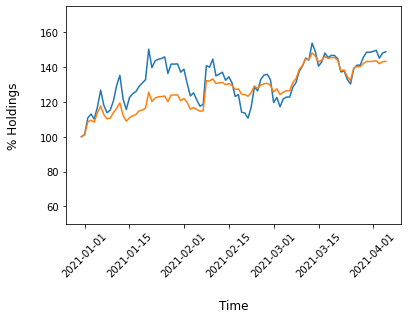

In [62]:
returns_without_adj2 = backtest_classification_noSentiment(yhat2, 
                                                      data.date.tolist(), 
                                                      "LSTM_classification_no_sentiment")
returns_with_adj2 = backtest_classification_WithSentiment(yhat2, 
                                  data.date.tolist(), 
                                  sentiments, "LSTM_classification_with_sentiment")

plt.plot([data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist(), [100*x for x in returns_without_adj2])
plt.plot([data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist(), [100*x for x in returns_with_adj2])
plt.xticks(rotation = 45)
plt.ylim(bottom = 50, top = 175)
plt.ylabel("% Holdings", labelpad = 20, fontsize = 12)
plt.xlabel("Time", labelpad = 20, fontsize = 12)
plt.show()